In [ ]:
!pip install tensorflow

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense

In [ ]:
import torch
import torchvision
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_folder = '/content/drive/My Drive/unknown'
yes_drone_folder ='/content/drive/My Drive/yes_drone'

In [ ]:
data = []
labels = []

for filename in os.listdir(yes_drone_folder):
    if filename.endswith(".wav"):
        audio_path = os.path.join(yes_drone_folder, filename)
        audio, sr = librosa.load(audio_path, sr=None)


        spectrogram = np.abs(librosa.stft(audio))
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
        resized_spectrogram = resize(spectrogram_db, (224, 224), mode='reflect')

        data.append(resized_spectrogram)
        labels.append(1)

for filename in os.listdir(dataset_folder):
    if filename.endswith(".wav"):
        audio_path = os.path.join(dataset_folder, filename)
        audio, sr = librosa.load(audio_path, sr=None)

        spectrogram = np.abs(librosa.stft(audio))
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

        resized_spectrogram = resize(spectrogram_db, (224, 224), mode='reflect')

        data.append(resized_spectrogram)
        labels.append(0)

X = np.array(data)
y = np.array(labels)

In [ ]:
print(X.shape)
print(y.shape)

(1028, 224, 224)
(1028,)


In [ ]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, so use sigmoid activation
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
23/23 [==============================] - 74s 3s/step - loss: 69.9795 - accuracy: 0.5925 - val_loss: 0.8815 - val_accuracy: 0.4935
Epoch 2/10
23/23 [==============================] - 68s 3s/step - loss: 0.5974 - accuracy: 0.7747 - val_loss: 0.2869 - val_accuracy: 0.8247
Epoch 3/10
23/23 [==============================] - 67s 3s/step - loss: 0.1387 - accuracy: 0.9444 - val_loss: 0.3756 - val_accuracy: 0.8571
Epoch 4/10
23/23 [==============================] - 65s 3s/step - loss: 0.2852 - accuracy: 0.8901 - val_loss: 0.3236 - val_accuracy: 0.8766
Epoch 5/10
23/23 [==============================] - 67s 3s/step - loss: 0.1681 - accuracy: 0.9346 - val_loss: 0.2122 - val_accuracy: 0.9221
Epoch 6/10
23/23 [==============================] - 65s 3s/step - loss: 0.1755 - accuracy: 0.9569 - val_loss: 0.3748 - val_accuracy: 0.9026
Epoch 7/10
23/23 [==============================] - 68s 3s/step - loss: 0.2887 - accuracy: 0.9235 - val_loss: 0.2724 - val_accuracy: 0.9221
Epoch 8/10
23/23 [=

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

5/5 [==============================] - 4s 653ms/step - loss: 0.2526 - accuracy: 0.9355
Test Loss: 0.2526, Test Accuracy: 0.9355


In [ ]:
model.save('/content/drive/My Drive/CNNModel.h5')

In [ ]:
# model = load_model('/content/drive/My Drive/CNNModel.h5')

new_audio_path = '/content/drive/My Drive/3-171041-A-383.wav'
new_audio, sr = librosa.load(new_audio_path, sr=None)
spectrogram = np.abs(librosa.stft(new_audio))
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
resized_spectrogram = resize(spectrogram_db, (224, 224), mode='reflect')
input_data = resized_spectrogram[np.newaxis, ...,np.newaxis]

In [ ]:
print(input_data.shape)

(1, 224, 224, 1)


In [ ]:
predicted_probability = model.predict(input_data)[0][0]

threshold = 0.5
if predicted_probability > threshold:
    classification = "Drone"
else:
    classification = "Not Drone"

print(f"Predicted Probability: {predicted_probability:.4f}")
print(f"Classification: {classification}")

1/1 [==============================] - 0s 236ms/step
Predicted Probability: 0.0017
Classification: Not Drone


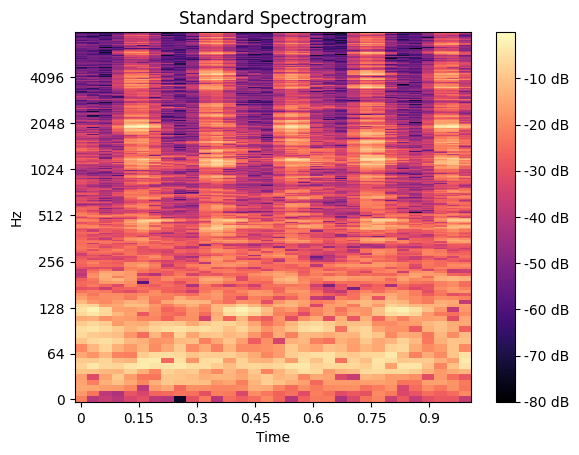

In [ ]:
spectrogram = np.abs(librosa.stft(new_audio))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Standard Spectrogram')
plt.show()